In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

from py_helper_functions import *

warnings.filterwarnings("ignore")

In [2]:
data_earnings = pd.read_csv("https://osf.io/4ay9x/download")

In [3]:
data_earnings.shape

(149316, 23)

In [4]:
data_earnings.columns

Index(['Unnamed: 0', 'hhid', 'intmonth', 'stfips', 'weight', 'earnwke',
       'uhours', 'grade92', 'race', 'ethnic', 'age', 'sex', 'marital',
       'ownchild', 'chldpres', 'prcitshp', 'state', 'ind02', 'occ2012',
       'class', 'unionmme', 'unioncov', 'lfsr94'],
      dtype='object')

In [6]:
selected_job_codes = [500,510,520,530,540,565,600,630,640,650,700,710,725,726,735,740,
                      800, 810, 820, 830, 840, 850, 860, 900, 910, 930, 940, 950]
buss_fin_occ_data = data_earnings[data_earnings['occ2012'].isin(selected_job_codes)]
#buss_fin_occ_data = data_earnings.loc[data_earnings["occ2012"] == 840, :]

In [7]:
buss_fin_occ_data['grade92'].unique()

array([43, 44, 42, 39, 41, 40, 45, 46, 38, 32, 36, 37, 34, 33, 35, 31],
      dtype=int64)

In [8]:
# We want to focus on employees with a graduate degree (more than bachelor's degree -> master's, 
# professional, and doctoral degree)
# Select people aged 24-65
# Exclude those who reported >=20 hours weekly time worked 
# And those with nonpositive reported earnings
buss_fin_occ_data = buss_fin_occ_data.query("uhours>=20 & earnwke>0 & age>=24 & age<=64")

In [9]:
# There are 6915 observations under "Business and Financial Operations Occupations" title after some filters
buss_fin_occ_data.shape

(6915, 23)

In [10]:
number_of_females = len(buss_fin_occ_data[buss_fin_occ_data["sex"] == 2])
number_of_males = len(buss_fin_occ_data[buss_fin_occ_data["sex"] == 1])

In [11]:
# There are 4079 females and 2836 males (total 6915) working in Business and Financial Operations Occupations 
print(number_of_females)
print(number_of_males)

4079
2836


Create variables for the intended study/research

- female
- hourly wages
- log of hourly wages (dependent variable)
- higher education categories

In [12]:
buss_fin_occ_data["female"] = (buss_fin_occ_data["sex"] == 2)
buss_fin_occ_data["w"] = buss_fin_occ_data["earnwke"] / buss_fin_occ_data["uhours"]
buss_fin_occ_data["lnw"] = np.log(buss_fin_occ_data["w"])

In [13]:
buss_fin_occ_data['ed_BA'] = (~buss_fin_occ_data['grade92'].isin([44, 45, 46])).astype(int) #bachelor or less 
buss_fin_occ_data["ed_MA"] = (buss_fin_occ_data["grade92"] == 44).astype(int) #master
buss_fin_occ_data["ed_Profess"] = (buss_fin_occ_data["grade92"] == 45).astype(int) #professional
buss_fin_occ_data["ed_Phd"] = (buss_fin_occ_data["grade92"] == 46).astype(int) #PhD

### Visualize Distribution of Wages 

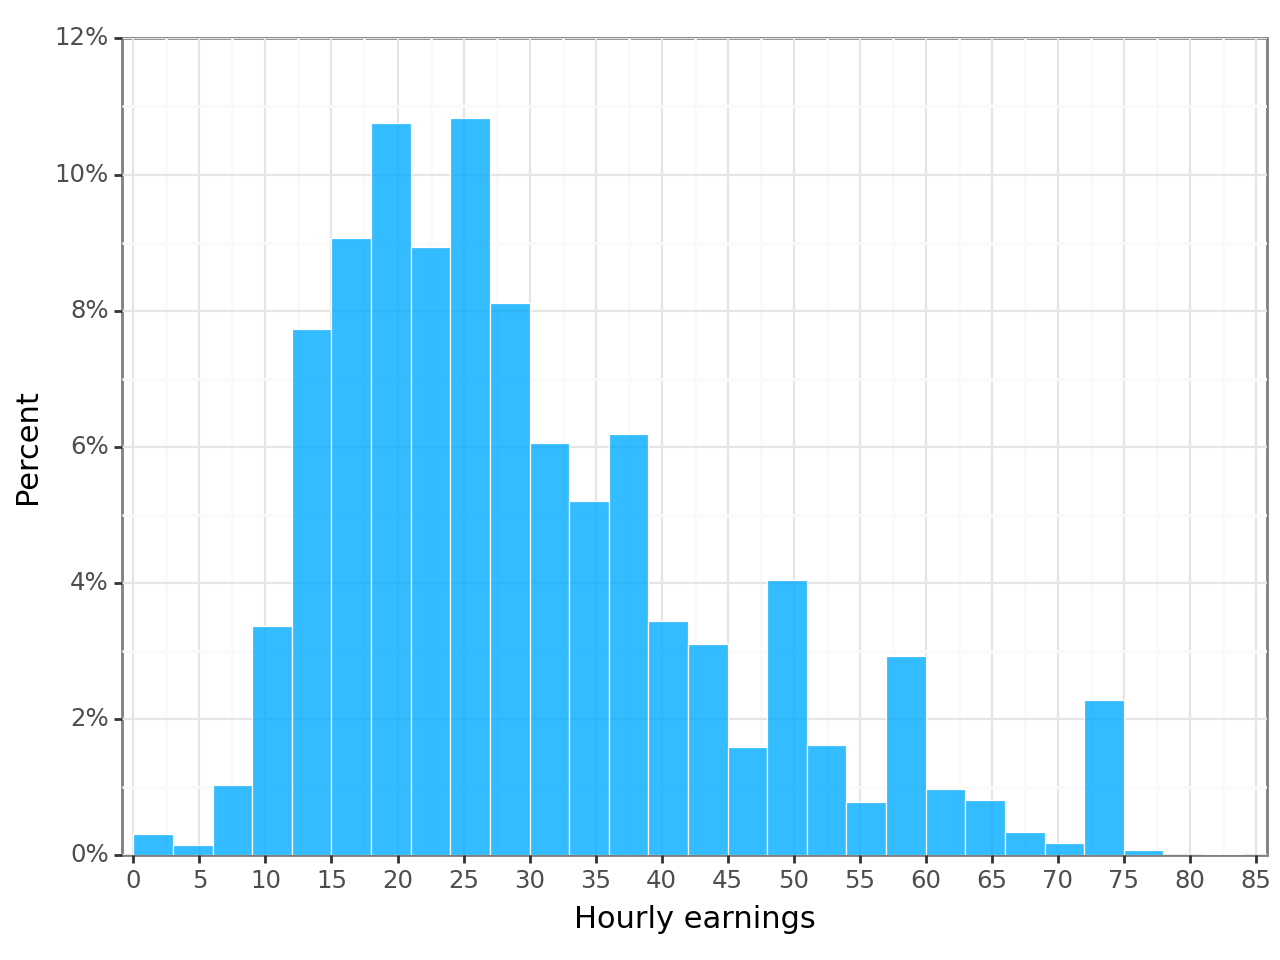

<Figure Size: (640 x 480)>

In [14]:
(
    ggplot(buss_fin_occ_data, aes(x="w", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill= "#00abff",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Hourly earnings", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 85), breaks=seq(0, 85, 5))
    + scale_y_continuous(
        labels=percent_format(), #mizani
        breaks=seq(0, 0.12, 0.02),
        limits=(0, 0.12),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)

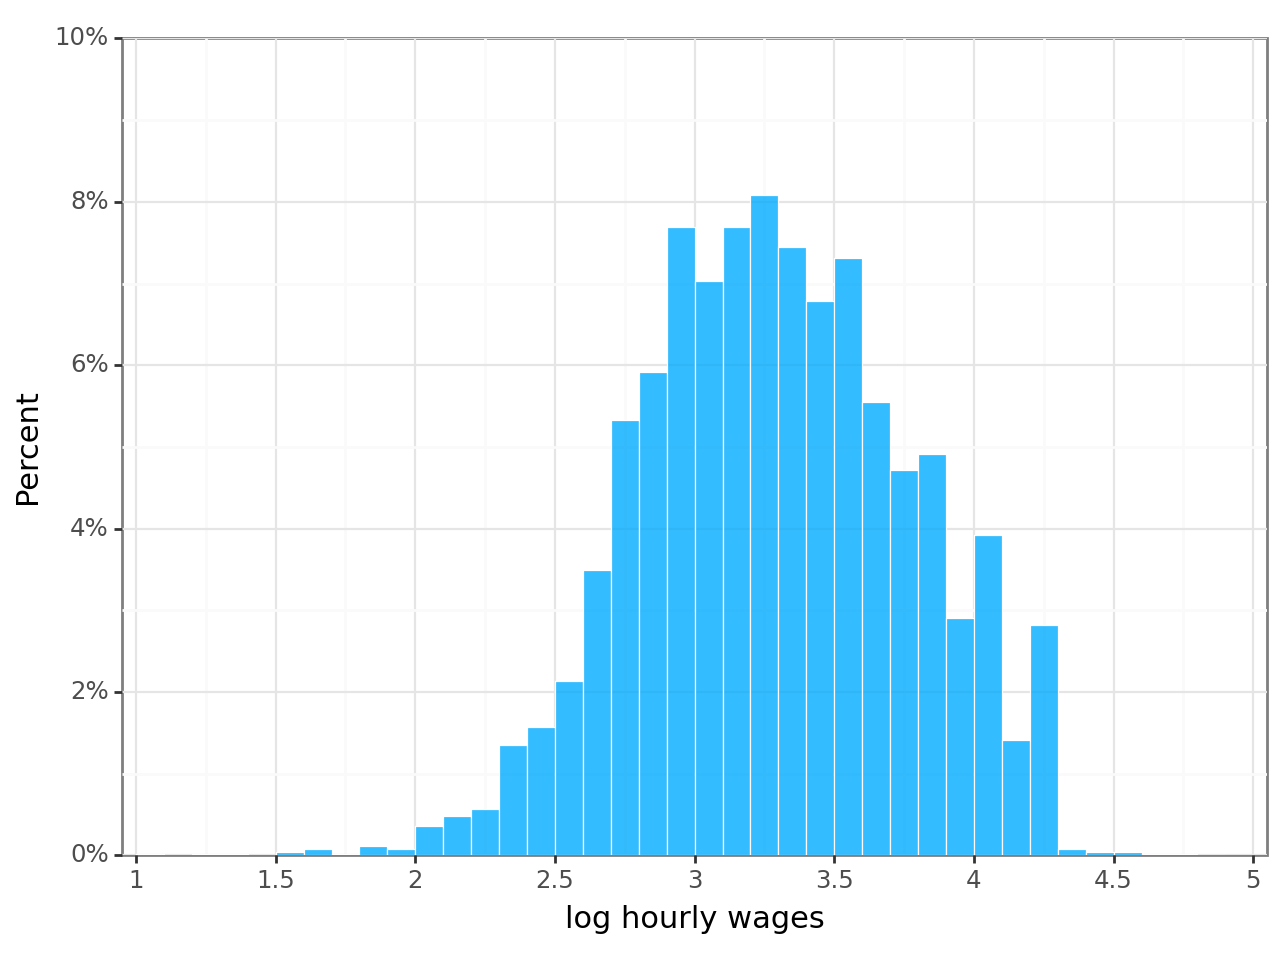

<Figure Size: (640 x 480)>

In [15]:
(
    ggplot(buss_fin_occ_data, aes(x="lnw", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        color="white",
        fill="#00abff",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="log hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 5, 0.5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        breaks=seq(0, 0.1, 0.02),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)

Logaritmic transformation results in a better distribution

### Visualize Wages by Gender and Education Level

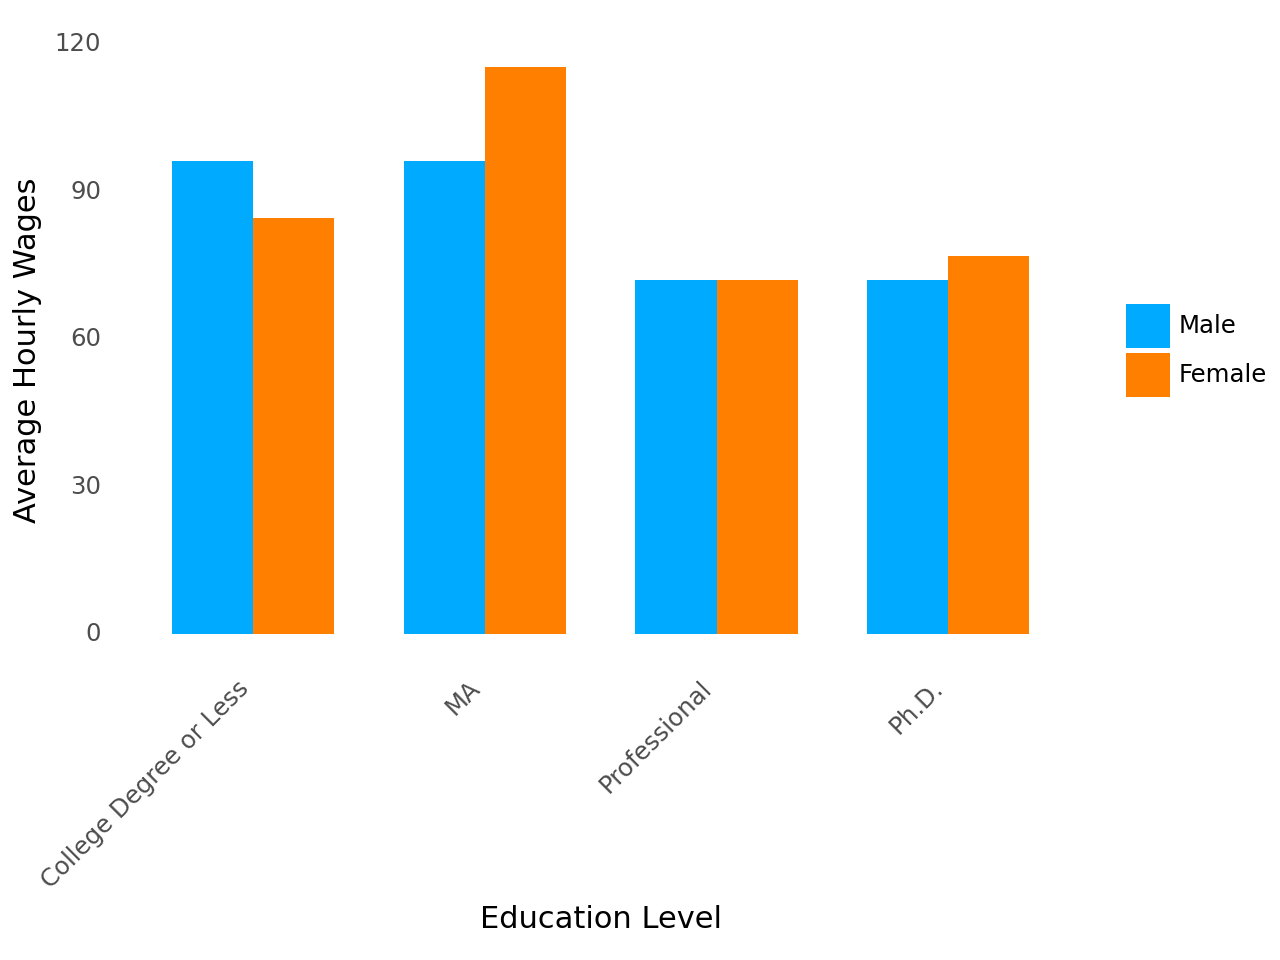

<Figure Size: (640 x 480)>

In [16]:
# Select relevant data for the chart
chart_data = buss_fin_occ_data[['female', 'ed_BA', 'ed_MA', 'ed_Profess', 'ed_Phd', 'w']]

# Create a new variable representing "College Degree or Less"
chart_data['education'] = pd.Categorical(np.argmax(chart_data[['ed_BA', 'ed_MA', 'ed_Profess', 'ed_Phd']].values, axis=1),
                                          categories=[0, 1, 2, 3], ordered=True)

# Map the values of the new variable to labels
education_labels = {0: 'College Degree or Less', 1: 'MA', 2: 'Professional', 3: 'Ph.D.'}
chart_data['education_label'] = chart_data['education'].map(education_labels)

# Melt the data for easier plotting
chart_data_melted = pd.melt(chart_data, id_vars=['female', 'education', 'education_label'], value_vars='w')

# Create the grouped bar chart
(
    ggplot(chart_data_melted, aes(x='education_label', y='value', fill='factor(female)')) +
    geom_bar(stat='identity', position='dodge', width=0.7, size=0.25) +  # Set color to 'white' and size to 0.25
    scale_fill_manual(values=["#00abff", "#ff7f00"], labels=["Male", "Female"]) +
    labs(x='Education Level', y='Average Hourly Wages') #, title='Wage Changes by Gender and Education') 
    + theme_minimal() +
    theme(axis_text_x=element_text(angle=45, hjust=1),  # Rotate x-axis labels for better readability
          legend_title=element_blank(),  # Remove legend title
          panel_grid_major=element_blank(),  # Remove major gridlines
          panel_grid_minor=element_blank())  # Remove minor gridlines
)

From the grouped bar chart, it seems higher education reduces the gender earnings gap.

### Descriptive Table for Selected Variables

In [26]:
buss_fin_occ_data = buss_fin_occ_data.query("grade92>=44")
print(buss_fin_occ_data.shape) # removed observations with less than MA degree
buss_fin_occ_data.loc[:, ["earnwke", "uhours", "w", "lnw"]].describe()

(1302, 30)


,earnwke,uhours,w,lnw
count,1302.000000,1302.000000,1302.000000,1302.000000
mean,1576.914117,43.076037,36.478251,3.483487
std,727.164232,7.548128,15.872176,0.577945
min,1.000000,20.000000,0.025000,-3.688879
25%,1000.000000,40.000000,24.038250,3.179646
50%,1442.300000,40.000000,33.701917,3.517554
75%,2047.115000,45.000000,48.075000,3.872762
max,2884.610000,90.000000,115.384400,4.748269


In [18]:
buss_fin_occ_data["female"] = buss_fin_occ_data["female"].astype(int)  #from boolean to 0,1
buss_fin_occ_data["female"].value_counts()

female
0    661
1    641
Name: count, dtype: int64

### Earnings and female gender
#### Linear regressions
**Log-level**:

$(\ln{w})^E = \alpha + \beta \times female$

In [19]:
reg1 = smf.ols(formula="lnw~female", data=buss_fin_occ_data).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     50.58
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           1.89e-12
Time:                        05:07:09   Log-Likelihood:                -1108.3
No. Observations:                1302   AIC:                             2221.
Df Residuals:                    1300   BIC:                             2231.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5936      0.022    162.878      0.000       3.550       3.637
female        -0.2236      0.031     -7.112      0.000      -0.285      -0.162
==============================================================================
Omnibus:                     1352.287   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           158602.512
Skew:                          -4.707   Prob(JB):                         0.00
Kurtosis:                      56.244   Cond. No.                         2.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
reg2 = smf.ols(formula="w~female", data=buss_fin_occ_data).fit(cov_type="HC1") 
reg3 = smf.ols(formula="lnw~female", data=buss_fin_occ_data).fit(cov_type="HC1") 
#heteroskedastic-consistent standard errors
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     50.00
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           2.50e-12
Time:                        05:07:09   Log-Likelihood:                -1108.3
No. Observations:                1302   AIC:                             2221.
Df Residuals:                    1300   BIC:                             2231.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5936      0.018    204.786      0.000       3.559       3.628
female        -0.2236      0.032     -7.071      0.000      -0.286      -0.162
==============================================================================
Omnibus:                     1352.287   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           158602.512
Skew:                          -4.707   Prob(JB):                         0.00
Kurtosis:                      56.244   Cond. No.                         2.60
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Robust SE slope: 0.032, CI  [−0.29, -0.16] (wide range probably due to small number of observations)

-> in 2014 in the USA we can be 95% confident that the ifference between hourly earnings of female market analysts versus male was -29% to -16% and on everage -22%

-> the CI does not includes zero -> we can rule out with 95% confidence that their average earnings (female and male) are the same

->  |𝑡|= 7 > 1.96
    reject  𝐻0
 
-> it can be seen also by p-value < 0.05
 
-> the coefficient canconsidered statistically significant at 5% (even at 1%)

### Wage and gender gap baseline regression

In [21]:
stargazer = Stargazer([reg1, reg2, reg3])
stargazer.covariate_order(["female", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

Slope: female in Business and Financial Operations Occupations earn 22\% ($\beta\times 100\%$) less, on average than male in the same occupations (in this data).
Gender coefficient is statistically significant at 1% (p<0.01). <

Using nominal hourly wages ('w') in 2nd regression gives also a negative coefficient but in this case it is more difficult to interpret.

### Gender differences in earnings – log earnings, gender and education

-> the category not represented is the **reference category**

-> coefficients on each $k-1$ dummy show average differences in $y$ compared to the reference category

-> also include interactions term to see the chnage of gender gap as education level changes

In [22]:
reg4 = smf.ols(formula="lnw~female + ed_Profess + ed_MA", data=buss_fin_occ_data).fit(cov_type="HC1")
reg5 = smf.ols(formula="lnw~female + ed_Profess + ed_Phd", data=buss_fin_occ_data).fit(cov_type="HC1")
reg6 = smf.ols(formula="lnw ~ female + ed_Profess + ed_Phd + female:ed_Profess + female:ed_Phd", data=buss_fin_occ_data).fit(cov_type="HC1")

In [23]:
stargazer = Stargazer([reg1, reg2, reg3, reg4, reg5, reg6])
stargazer.covariate_order(["female", "ed_MA", "ed_Profess", "ed_Phd", "female:ed_Profess", "female:ed_Phd", "Intercept"])

stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

Controlling for level of education in the regression decreases the level of gender gap (coefficient of 'female' is smaller very little) in 4th and 5th regressions. However, 4th and 5th regressions does not give us how gap changes as education level changes. In 6th regression we introduced interaction terms of 'female' with different levels of gradute degrees. In this regression we see that interaction term betwwen 'female' and 'ed_Profess' is very small and statistically not significant. Interaction term betwwen 'female' and 'ed_Phd' is +29% and statistically significant. That means females with a PhD degree earn 29% percent higher than their male counterparts. We can roughly say that the gender gap decreases as education level increases.